Mounted at /content/drive
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Copying files: 253 files [00:01, 242.67 files/s]


Dataset ImageFolder
    Number of datapoints: 202
    Root location: /content/brain/train
    StandardTransform
Transform: Compose(
               Resize(size=(128, 128), interpolation=bilinear, max_size=None, antialias=True)
               RandomHorizontalFlip(p=0.5)
               RandomVerticalFlip(p=0.5)
               RandomRotation(degrees=[-30.0, 30.0], interpolation=nearest, expand=False, fill=0)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )
Loss in Iteration: 0 : 0.6864651441574097
Loss in Iteration: 1 : 0.7237947583198547
Loss in Iteration: 2 : 0.6676183342933655
Loss in Iteration: 3 : 0.7823140621185303
Epoch:0  Loss:0.71504807472229  Accuracy:60.7843132019043%
Loss in Iteration: 0 : 0.6609135270118713
Loss in Iteration: 1 : 0.6099218726158142
Loss in Iteration: 2 : 0.6841985583305359
Loss in Iteration: 3 : 0.6992086172103882
Epoch:1  Loss:0.6635606437921524  Accuracy:74.50980377197266%
Loss in Iteratio

Epoch:9  Loss:0.6268888413906097  Accuracy:70.5882339477539%
Predicted Output: 0


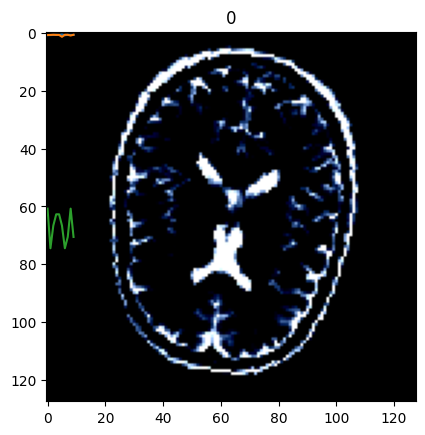

In [1]:
!pip install split-folders
import numpy as np
import matplotlib.pyplot as plt
import copy
import os
import torch
from PIL import Image
from torch.utils.data import Dataset
import torchvision
import torchvision.transforms as transforms
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.nn as nn
from torchvision import utils
from torchvision.datasets import ImageFolder
import splitfolders
import torch.nn.functional as F
import pathlib
from torch import optim
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')
import zipfile

# Step 2: Specify the path to the zip file in Google Drive
zip_file_path = '/content/drive/MyDrive/Brain Tumor Data Set.zip'
extract_dir = '/content/drive/MyDrive/Brain Tumor Data Set'

# Ensure the extract directory exists
os.makedirs(extract_dir, exist_ok=True)

# Step 3: Unzip the file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)
os.listdir("/content/drive/MyDrive/Brain Tumor Data Set/brain_tumor_dataset")
from google.colab import drive
drive.mount('/content/drive')
data_dir = "/content/drive/MyDrive/Brain Tumor Data Set/brain_tumor_dataset"
data_dir = pathlib.Path(data_dir)

splitfolders.ratio(data_dir, output='brain', seed=41, ratio=(0.8, 0.2))
data_dir = "/content/brain"
data_dir = pathlib.Path(data_dir)
transform = transforms.Compose(
    [
        transforms.Resize((128,128)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomVerticalFlip(p=0.5),
        transforms.RandomRotation(30),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]
)
train_set = torchvision.datasets.ImageFolder(data_dir.joinpath('train'), transform=transform)
train_set.transform
val_set = torchvision.datasets.ImageFolder(data_dir.joinpath('val'), transform=transform)
val_set.transform
print(train_set)
batch_size = 64
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
next(iter(val_loader))[0].shape
class CNNModel(nn.Module):
  def __init__(self):
    super(CNNModel, self).__init__()

    #Conv 1
    self.cnv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=5, stride=1, padding=0) #128-5+1=124

    #Max Pool 1
    self.maxpool1 = nn.MaxPool2d(kernel_size=2) #124/2 = 64

    #Conv 2
    self.cnv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, stride=1, padding=0) #60

    #Max Pool 2
    self.maxpool2 = nn.MaxPool2d(kernel_size=2) #30

    #Conv 3
    self.cnv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, stride=1, padding=0) #26

    #Max Pool 3
    self.maxpool3 = nn.MaxPool2d(kernel_size=2) #13

    #Conv 4
    self.cnv4 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=5, stride=1, padding=0) #9

    #Max Pool 4
    self.maxpool4 = nn.MaxPool2d(kernel_size=2) #4

    #Activation Function
    self.prelu = nn.PReLU()

    #Fully connected Layer 1
    self.fc1 = nn.Linear(128*4*4, 1024)

    #Fully connected Layer 2
    self.fc2 = nn.Linear(1024, 2)

  def forward(self, x):
    #Layer 1
    out = self.prelu(self.cnv1(x))
    out = self.maxpool1(out)

    #Layer 2
    out = self.prelu(self.cnv2(out))
    out = self.maxpool2(out)

    #Layer 3
    out = self.prelu(self.cnv3(out))
    out = self.maxpool3(out)

    #Layer 4
    out = self.prelu(self.cnv4(out))
    out = self.maxpool4(out)

    #flatten
    out = out.view(out.size(0), -1)

    # Linear Function
    out = self.prelu(self.fc1(out))
    out = self.fc2(out)

    return out
# Training CNN
num_epochs = 10
model = CNNModel()
error = nn.CrossEntropyLoss()

lr = 0.001
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)
train_loss_list = []
val_loss_list = []
accuracy_list = []

for epoch in range(num_epochs):
  train_loss = 0
  val_loss = 0
  for i, (images, labels) in enumerate(train_loader):

    optimizer.zero_grad()
    outputs = model(images)
    loss = error(outputs, labels)
    train_loss+=loss.item()
    loss.backward()
    optimizer.step()
    print("Loss in Iteration:", i, ":", loss.item())
  total = 0
  correct = 0
  for images, labels in val_loader:
    outputs = model(images)
    v_loss = error(outputs, labels)
    val_loss+=v_loss.item()
    predicted = torch.max(outputs.data, 1)[1]

    total+=len(labels)
    correct+=(predicted==labels).sum()

  scheduler.step(val_loss/len(val_loader))
  accuracy = 100*correct/float(total)
  train_loss_list.append(train_loss/len(train_loader))
  val_loss_list.append(val_loss/len(val_loader))
  accuracy_list.append(accuracy)
  print("Epoch:{}  Loss:{}  Accuracy:{}%".format(epoch, train_loss/len(train_loader), accuracy))
train_loss_list
val_loss_list
plt.plot(range(num_epochs), train_loss_list)
plt.plot(range(num_epochs), val_loss_list)
accuracy_list
plt.plot(range(num_epochs), accuracy_list)
img, label = val_set[5]
plt.imshow(img.permute(1,2,0))
plt.title(label)
image = img.unsqueeze(0)

with torch.no_grad():
  output = model(image)

_, pred = torch.max(output, 1)
print("Predicted Output:", pred.item())
